# Teams Basic Modeling 

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [2]:
# load batting_basic
team_merged = pd.read_csv('Data/team_merged', index_col = 0)

# remove extra features that wont be modelled
team_merged = team_merged.drop(columns = ['Team', 'Year', 'Losses'])

# remove attendance = 0 rows
team_merged = team_merged[team_merged['Attendance'] > 0]

team_merged

,Attendance,Wins,ERA_p,G_p,GS_p,CG_p,ShO_p,SV_p,IP_p,TBF_p,H_p,R_p,ER_p,HR_p,BB_p,IBB_p,HBP_p,WP_p,BK_p,SO_p,K/9_p,BB/9_p,K/BB_p,H/9_p,HR/9_p,AVG_p,WHIP_p,BABIP_p,LOB%_p,FIP_p,Age_b,AB_b,PA_b,H_b,1B_b,2B_b,3B_b,HR_b,R_b,RBI_b,BB_b,IBB_b,SO_b,HBP_b,SF_b,SH_b,GDP_b,SB_b,CS_b,AVG_b,BB%_b,K%_b,BB/K_b,OBP_b,SLG_b,OPS_b,ISO_b,BABIP_b
0,1187849.0,89.0,3.52,331.0,154.0,48.0,10.0,22.0,1375.2,5772.0,1222.0,606.0,538.0,117.0,552.0,19.0,34.0,34.0,2.0,785.0,5.14,3.61,1.42,7.99,0.77,0.236,1.29,0.258,0.731,3.77,29.0,5170.0,5911.0,1307.0,945.0,206.0,33.0,123.0,682.0,640.0,596.0,36.0,800.0,36.0,37.0,72.0,127.0,37.0,24.0,0.253,0.101,0.135,0.75,0.332,0.377,0.709,0.124,0.276
1,1129866.0,65.0,4.62,406.0,154.0,34.0,6.0,23.0,1361.0,6029.0,1440.0,775.0,699.0,127.0,580.0,53.0,36.0,55.0,5.0,767.0,5.07,3.84,1.32,9.52,0.84,0.266,1.48,0.291,0.682,3.97,28.0,5215.0,5931.0,1359.0,969.0,234.0,32.0,124.0,658.0,623.0,570.0,33.0,799.0,25.0,51.0,70.0,153.0,34.0,28.0,0.261,0.096,0.135,0.71,0.333,0.389,0.722,0.128,0.284
2,1644460.0,87.0,3.60,408.0,154.0,42.0,10.0,26.0,1381.0,5871.0,1338.0,617.0,553.0,127.0,533.0,36.0,16.0,22.0,0.0,695.0,4.53,3.47,1.30,8.72,0.83,0.251,1.35,0.269,0.743,3.91,30.0,5191.0,5966.0,1402.0,1010.0,242.0,38.0,112.0,741.0,684.0,567.0,36.0,648.0,54.0,59.0,95.0,133.0,122.0,48.0,0.270,0.095,0.109,0.88,0.345,0.396,0.741,0.126,0.287
3,809770.0,60.0,4.35,416.0,156.0,36.0,5.0,25.0,1402.2,6075.0,1393.0,776.0,678.0,152.0,565.0,56.0,42.0,39.0,4.0,805.0,5.17,3.63,1.42,8.94,0.98,0.255,1.40,0.275,0.685,4.09,27.0,5311.0,5960.0,1293.0,913.0,213.0,48.0,119.0,634.0,600.0,531.0,69.0,897.0,19.0,35.0,64.0,109.0,51.0,34.0,0.243,0.089,0.151,0.59,0.313,0.369,0.681,0.125,0.271
4,663486.0,67.0,4.00,407.0,154.0,33.0,7.0,35.0,1390.1,5904.0,1417.0,692.0,618.0,134.0,442.0,53.0,42.0,33.0,2.0,740.0,4.79,2.86,1.67,9.17,0.87,0.261,1.34,0.282,0.706,3.76,27.0,5289.0,5940.0,1324.0,914.0,230.0,40.0,140.0,640.0,604.0,512.0,44.0,858.0,34.0,45.0,60.0,110.0,73.0,37.0,0.250,0.086,0.144,0.60,0.318,0.388,0.706,0.138,0.273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,2102530.0,90.0,4.00,718.0,162.0,3.0,1.0,50.0,1417.0,6046.0,1234.0,672.0,629.0,152.0,608.0,30.0,85.0,66.0,4.0,1225.0,7.78,3.86,2.01,7.84,0.97,0.231,1.30,0.272,0.732,4.30,28.0,5351.0,6001.0,1303.0,822.0,261.0,22.0,198.0,706.0,678.0,478.0,32.0,1341.0,86.0,44.0,40.0,99.0,89.0,22.0,0.244,0.080,0.223,0.36,0.313,0.412,0.725,0.168,0.287
1620,761072.0,100.0,3.67,693.0,162.0,1.0,0.0,42.0,1455.2,5998.0,1264.0,651.0,594.0,184.0,436.0,27.0,55.0,64.0,6.0,1478.0,9.14,2.70,3.39,7.81,1.14,0.230,1.17,0.281,0.737,3.79,28.0,5507.0,6213.0,1336.0,790.0,288.0,36.0,222.0,857.0,810.0,585.0,27.0,1542.0,72.0,41.0,6.0,75.0,88.0,42.0,0.243,0.094,0.248,0.38,0.321,0.429,0.750,0.186,0.294
1621,2110258.0,60.0,4.80,669.0,162.0,0.0,0.0,31.0,1424.1,6103.0,1402.0,815.0,760.0,232.0,513.0,11.0,61.0,67.0,0.0,1239.0,7.83,3.24,2.42,8.86,1.47,0.254,1.34,0.288,0.703,4.76,27.0,5405.0,5943.0,1254.0,838.0,225.0,24.0,167.0,625.0,598.0,433.0,10.0,1381.0,58.0,31.0,16.0,113.0,106.0,29.0,0.232,0.073,0.232,0.31,0.294,0.375,0.670,0.143,0.280
1622,805901.0,91.0,3.91,698.0,162.0,1.0,1.0,34.0,1405.1,5916.0,1257.0,663.0,610.0,209.0,473.0,10.0,75.0,54.0,4.0,1468.0,9.40,3.03,3.10,8.05,1.34,0.234,1.23,0.284,0.755,4.18,28.0,5476.0,6070.0,1455.0,895.0,285.0,13.0,262.0,846.0,816.0,496.0,14.0,1218.0,51.0,35.0,10.0,112.0,81.0,20.0,0.266,0.082,0.201,0.41,0.330,0.466,0.797,0.200,0.296


## Checking Correlations Between Features

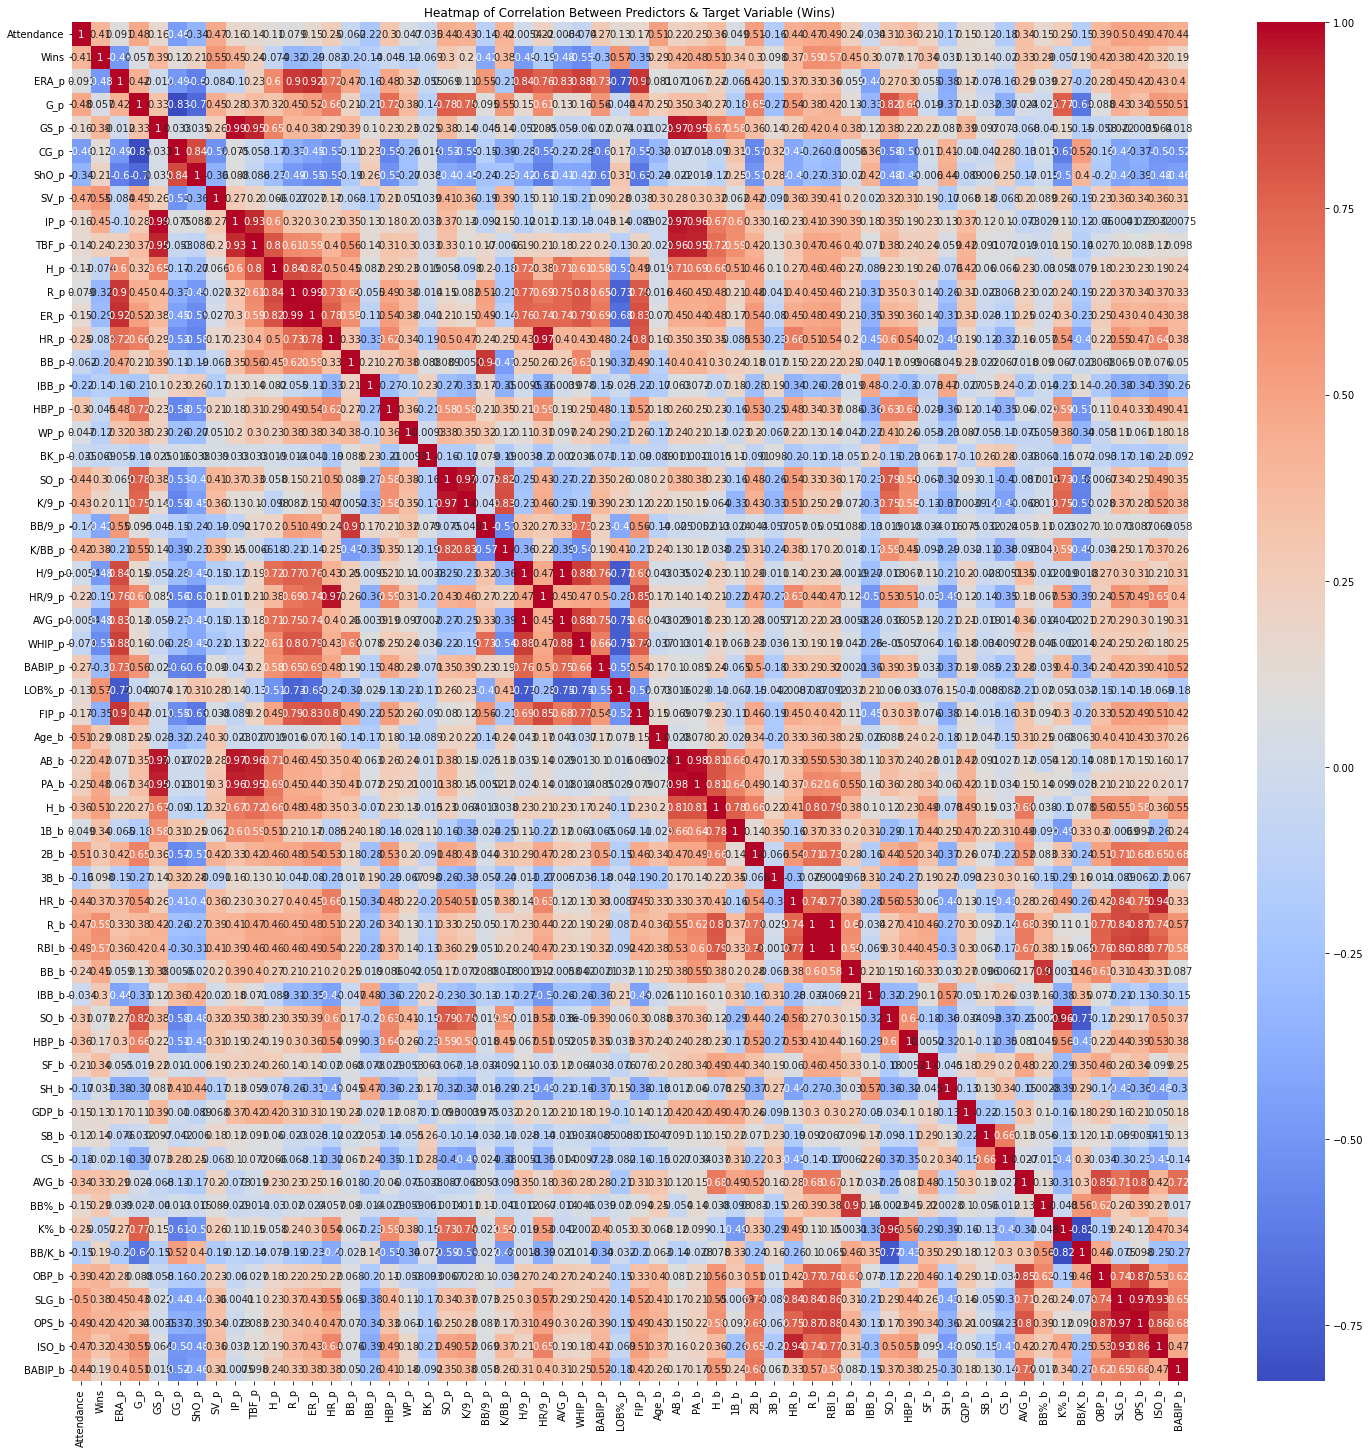

In [3]:
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = team_merged.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Wins)");

plt.show()

## Feature Selection

**Multicollinearity**

In [4]:
corr_df = team_merged.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [5]:
corr_df[(corr_df.cc>0.9) & (corr_df.cc <1)]

,cc
pairs,
"(AVG_p, H/9_p)",0.995812
"(RBI_b, R_b)",0.995487
"(R_p, ER_p)",0.986224
"(IP_p, GS_p)",0.986046
"(AB_b, PA_b)",0.978903
"(OPS_b, SLG_b)",0.974819
"(HR/9_p, HR_p)",0.974561
"(AB_b, GS_p)",0.967800
"(AB_b, IP_p)",0.966766


**Feature Selection Using `feature_selection`**

In [6]:
team_merged.columns

Index(['Attendance', 'Wins', 'ERA_p', 'G_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p',
       'IP_p', 'TBF_p', 'H_p', 'R_p', 'ER_p', 'HR_p', 'BB_p', 'IBB_p', 'HBP_p',
       'WP_p', 'BK_p', 'SO_p', 'K/9_p', 'BB/9_p', 'K/BB_p', 'H/9_p', 'HR/9_p',
       'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b', 'AB_b',
       'PA_b', 'H_b', '1B_b', '2B_b', '3B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'SO_b', 'HBP_b', 'SF_b', 'SH_b', 'GDP_b', 'SB_b', 'CS_b',
       'AVG_b', 'BB%_b', 'K%_b', 'BB/K_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b',
       'BABIP_b'],
      dtype='object')

In [7]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, mutual_info_regression

In [8]:
feature_selector = SelectKBest(mutual_info_regression, k = 40)

In [9]:
df = team_merged[['Attendance', 'ERA_p', 'G_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p',
       'IP_p', 'TBF_p', 'H_p', 'R_p', 'ER_p', 'HR_p', 'BB_p', 'IBB_p', 'HBP_p',
       'WP_p', 'BK_p', 'SO_p', 'K/9_p', 'BB/9_p', 'K/BB_p', 'H/9_p', 'HR/9_p',
       'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b', 'AB_b',
       'PA_b', 'H_b', '1B_b', '2B_b', '3B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'SO_b', 'HBP_b', 'SF_b', 'SH_b', 'GDP_b', 'SB_b', 'CS_b',
       'AVG_b', 'BB%_b', 'K%_b', 'BB/K_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b',
       'BABIP_b']]

In [10]:
feature_selector.fit(df, team_merged['Wins'])

# get top features
df.columns[feature_selector.get_support()]

Index(['Attendance', 'ERA_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p', 'IP_p', 'TBF_p',
       'H_p', 'R_p', 'ER_p', 'HR_p', 'BB_p', 'SO_p', 'BB/9_p', 'K/BB_p',
       'H/9_p', 'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'AB_b',
       'PA_b', 'H_b', '1B_b', '2B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b', 'IBB_b',
       'HBP_b', 'SF_b', 'AVG_b', 'BB%_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b'],
      dtype='object')

## Train-Test Split

Define the X as features we want to keep for the Train-Test Split

In [11]:
team_merged.columns

Index(['Attendance', 'Wins', 'ERA_p', 'G_p', 'GS_p', 'CG_p', 'ShO_p', 'SV_p',
       'IP_p', 'TBF_p', 'H_p', 'R_p', 'ER_p', 'HR_p', 'BB_p', 'IBB_p', 'HBP_p',
       'WP_p', 'BK_p', 'SO_p', 'K/9_p', 'BB/9_p', 'K/BB_p', 'H/9_p', 'HR/9_p',
       'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b', 'AB_b',
       'PA_b', 'H_b', '1B_b', '2B_b', '3B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'SO_b', 'HBP_b', 'SF_b', 'SH_b', 'GDP_b', 'SB_b', 'CS_b',
       'AVG_b', 'BB%_b', 'K%_b', 'BB/K_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b',
       'BABIP_b'],
      dtype='object')

In [13]:
top_features = ['Attendance', 'ERA_p', 'GS_p', 'CG_p', 'SV_p', 'IP_p', 'TBF_p', 'H_p',
       'R_p', 'ER_p', 'HR_p', 'BB_p', 'WP_p', 'SO_p', 'BB/9_p', 'K/BB_p',
       'H/9_p', 'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b',
       'AB_b', 'PA_b', 'H_b', '1B_b', '2B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'HBP_b', 'SF_b', 'AVG_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b']

In [35]:
# feature selection, target variable = 'W'
X = team_merged[['Attendance', 'ERA_p', 'GS_p', 'CG_p', 'SV_p', 'IP_p', 'TBF_p', 'H_p',
       'R_p', 'ER_p', 'HR_p', 'BB_p', 'WP_p', 'SO_p', 'BB/9_p', 'K/BB_p',
       'H/9_p', 'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b',
       'AB_b', 'PA_b', 'H_b', '1B_b', '2B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'HBP_b', 'SF_b', 'AVG_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b']]

y = team_merged['Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [36]:
X_train.head(3)

,Attendance,ERA_p,GS_p,CG_p,SV_p,IP_p,TBF_p,H_p,R_p,ER_p,HR_p,BB_p,WP_p,SO_p,BB/9_p,K/BB_p,H/9_p,AVG_p,WHIP_p,BABIP_p,LOB%_p,FIP_p,Age_b,AB_b,PA_b,H_b,1B_b,2B_b,HR_b,R_b,RBI_b,BB_b,IBB_b,HBP_b,SF_b,AVG_b,OBP_b,SLG_b,OPS_b,ISO_b
777,3170393.0,3.50,162.0,17.0,36.0,1472.2,6274.0,1406.0,662.0,573.0,103.0,567.0,47.0,1043.0,3.47,1.84,8.59,0.248,1.34,0.288,0.722,3.71,28.0,5588.0,6261.0,1458.0,1066.0,234.0,130.0,675.0,639.0,492.0,48.0,27.0,47.0,0.261,0.321,0.383,0.704,0.122
486,1636058.0,3.81,162.0,45.0,27.0,1451.0,6115.0,1371.0,685.0,615.0,172.0,554.0,52.0,740.0,3.44,1.34,8.50,0.248,1.33,0.259,0.740,4.43,28.0,5590.0,6166.0,1489.0,1035.0,237.0,177.0,729.0,684.0,470.0,29.0,26.0,39.0,0.266,0.324,0.418,0.742,0.152
1392,2680329.0,4.86,162.0,1.0,24.0,1431.0,6248.0,1528.0,818.0,772.0,173.0,531.0,72.0,1074.0,3.34,2.02,9.61,0.270,1.44,0.307,0.692,4.43,27.0,5612.0,6164.0,1551.0,1017.0,307.0,186.0,755.0,721.0,397.0,39.0,48.0,48.0,0.276,0.327,0.445,0.772,0.169


In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1195, 40)
(399, 40)
(1195,)
(399,)


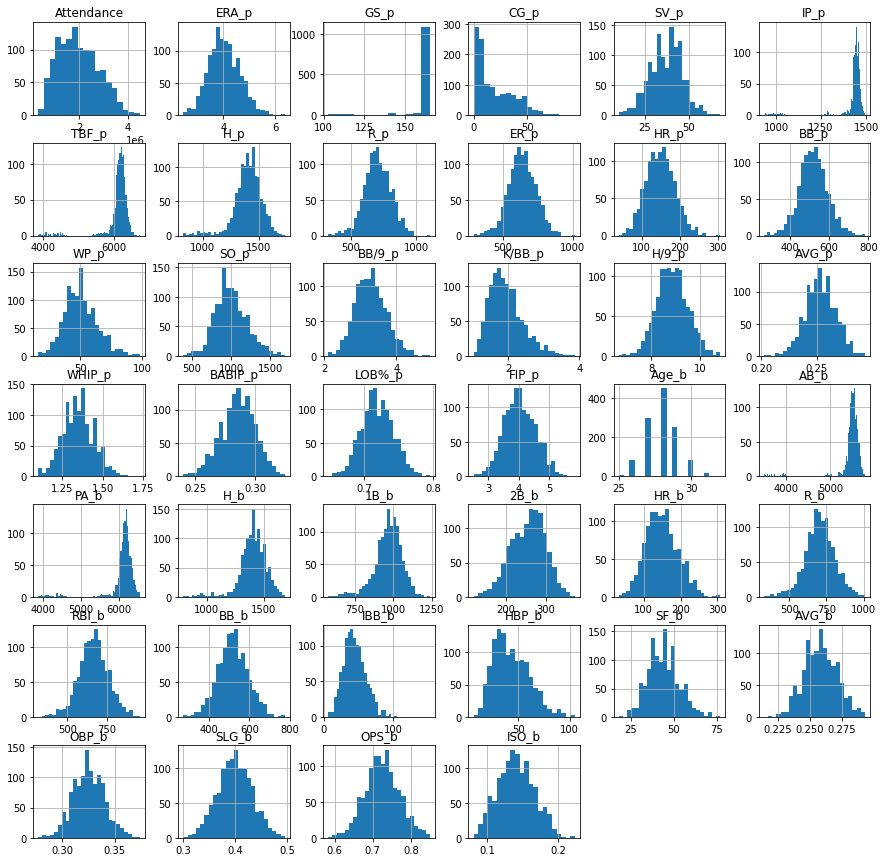

In [38]:
# check distribution of features
X_train.hist(figsize = [15,15], bins = 'auto')
plt.show()

## Preprocessing Pipeline 

In [39]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [40]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler()), # apply a standard scaler
#                              ('poly', PolynomialFeatures(interaction_only = True # interactions 
#                                                          )) 
                             ])

In [41]:
# transform the selected columns with nominal, and numeric pipelines
bb_teams_ct = ColumnTransformer(transformers = [("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformers

In [42]:
# save the transformer
dump(bb_teams_ct, open('pkl/bb_teams_ct.pkl', 'wb'))

In [43]:
# load the transformer
bb_teams_ct = load(open('pkl/bb_teams_ct.pkl', 'rb'))

**Transform `bb_teams`**

In [44]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_X_train = pd.DataFrame(bb_teams_ct.fit_transform(X_train))
pp_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1.482367,-0.893124,0.251848,-0.098322,-0.122925,0.516081,0.437015,0.016720,-0.422822,-0.669002,-1.229194,0.634454,-0.260009,0.209499,0.422969,-0.233844,-0.431313,-0.384431,-0.100385,0.147984,0.131928,-0.637922,0.012156,0.437083,0.404371,0.440050,1.088755,-0.497947,-0.450628,-0.313636,-0.276962,-0.370498,0.177609,-0.973204,0.312033,0.206492,-0.299397,-0.505646,-0.468212,-0.761866
1,-0.392392,-0.376038,0.251848,1.523897,-1.094314,0.276776,0.028171,-0.264348,-0.197839,-0.243995,0.603197,0.456482,0.114071,-1.248523,0.353571,-1.308049,-0.574503,-0.384431,-0.203710,-1.849051,0.911536,0.762180,0.012156,0.442906,0.159885,0.698291,0.746225,-0.428329,0.649308,0.233436,0.186393,-0.659969,-0.972920,-1.031092,-0.558418,0.591331,-0.099669,0.566094,0.378556,0.429640
2,0.883572,1.375385,0.251848,-1.025304,-1.418110,0.051016,0.370160,0.996441,1.103150,1.344718,0.629753,0.141610,1.610393,0.358670,0.122245,0.152870,1.191503,1.202175,0.932864,1.456386,-1.167419,0.762180,-0.895732,0.506957,0.154738,1.214771,0.547336,1.196087,0.859934,0.496842,0.567374,-1.620485,-0.367379,0.242453,0.420839,1.361008,0.100059,1.392865,1.047057,1.104826
3,0.864940,0.341212,0.251848,-0.793559,0.848464,0.131161,0.172166,0.185360,0.095617,0.383395,-0.220051,0.100539,-0.185193,0.743626,0.029714,0.518100,0.109626,0.120399,0.106265,0.905480,-0.257876,-0.151775,0.920043,-0.116086,0.352901,0.023534,-1.099018,1.033645,0.953546,0.993259,0.968948,1.840005,-0.306825,0.184565,1.726515,0.206492,1.165273,1.270380,1.314457,1.541712
4,-0.047476,0.007607,0.150413,2.450879,-1.526042,0.143578,0.005029,1.277508,0.164090,0.069700,0.337633,-1.911907,-0.185193,-2.018435,-2.098487,-0.921335,1.446062,1.490649,0.002940,-0.265196,-0.171253,0.353817,0.012156,0.285689,0.316871,1.223101,0.746225,0.824792,0.836531,1.023652,1.030729,0.379494,0.177609,-1.378423,0.638452,1.668879,1.298425,1.484728,1.515008,1.065110


In [45]:
pp_X_train.shape

(1195, 40)

Now lets do the same transformation for the `X_test`

In [46]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_X_test = pd.DataFrame(bb_teams_ct.transform(X_test))
pp_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,-0.564899,1.875791,0.150413,-0.735622,0.956396,0.108585,0.681293,1.494332,1.895481,1.870916,1.240550,0.648144,1.610393,-0.002227,0.631162,-0.405717,1.748352,1.707004,1.552813,1.456386,-1.730469,1.540015,0.012156,0.314803,0.224223,0.448381,0.481040,0.430291,-0.357017,0.081472,0.206987,-0.594180,-1.275691,0.937114,2.270547,0.360428,-0.099669,-0.015708,-0.022544,-0.205830
1,-0.017267,1.909152,0.353283,-0.967368,-0.662586,0.073592,0.753291,2.032376,1.797663,1.870916,1.851347,-0.392305,0.188887,-0.213953,-0.456071,-0.019003,2.464300,2.211833,1.552813,1.594112,-0.950861,1.617798,0.012156,0.370120,0.558784,0.398399,-0.955377,1.845853,1.702438,1.155355,1.216071,1.195275,-0.185716,1.052891,-0.558418,0.206492,0.898969,1.423486,1.336741,1.740296
2,-0.417726,1.558867,0.251848,-0.677686,0.740532,0.109714,0.588724,1.197203,1.367260,1.567341,0.709422,0.415412,0.338519,0.171004,0.376704,-0.147908,1.382423,1.274294,1.139513,1.249796,-1.427288,0.859410,0.012156,0.483665,0.270547,1.073155,1.497581,0.546320,-0.661254,-0.303505,-0.266665,-0.646811,-1.215137,-0.510096,0.964871,1.207073,0.366362,-0.015708,0.111156,-0.602998
3,-1.029133,0.474653,0.251848,1.118342,-1.310178,0.051016,0.205594,0.458397,0.584710,0.484587,-0.352833,0.620764,-0.484458,-1.349574,0.631162,-1.458438,0.523285,0.625228,0.726214,-0.402922,-1.124107,0.373263,-0.895732,0.230372,-0.040851,0.165150,0.348448,-0.010622,-0.567643,-0.678351,-0.699129,-1.015228,-1.336245,-1.262646,0.094420,-0.024411,-0.765428,-0.321919,-0.490495,-0.404414
4,0.445251,2.209396,0.251848,-0.967368,-0.554654,-0.072023,0.498727,1.470241,1.846572,2.093539,1.824791,0.237440,0.188887,0.974600,0.284173,0.604036,1.907451,1.779123,1.552813,2.351608,-1.383977,1.345556,0.012156,0.343917,0.118708,0.248453,-0.480254,0.778380,0.883337,0.294222,0.340845,-0.225763,-1.457354,0.474007,-1.864094,-0.024411,-0.099669,0.749821,0.512256,0.985676


In [47]:
pp_X_test.shape

(399, 40)

**Log Transforming Wins**

In [48]:
# basic y
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

## Modeling

In [49]:
# import my helper function to get model results
from functions import *

### Linear Regression

In [50]:
# build pipeline 
steps = [('preprocess', bb_teams_ct), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Attendance', 'ERA_p', 'GS_p', 'CG_p', 'SV_p', 'IP_p', 'TBF_p', 'H_p',
       'R_p', 'ER_p', 'HR_p', 'BB_p', 'WP_p', 'SO_p', 'BB/9_p', 'K/BB_p',
       'H/9_p', 'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b',
       'AB_b', 'PA_b', 'H_b', '1B_b', '2B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'HBP_b', 'SF_b', 'AVG_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [51]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.9342
LinearRegression() Test R2:                   0.9237
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.9258
LinearRegression() Cross Validation RMSE:    3
-------------------------------------------------------
LinearRegression() Training RMSE:            3
LinearRegression() Test RMSE:                3


## PCA

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=30) # Check out how `n_components` works

X_train_pca = pca.fit_transform(pp_X_train)
X_test_pca = pca.transform(pp_X_test)

In [34]:
lr_pca = LinearRegression()

# get model results
model_results(lr_pca, X_train_pca, log_y_train, X_test_pca, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.9213
LinearRegression() Test R2:                   0.9099
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.9131
LinearRegression() Cross Validation RMSE:    3
-------------------------------------------------------
LinearRegression() Training RMSE:            4
LinearRegression() Test RMSE:                4


In [32]:
lr_pca.coef_

array([-0.00821111, -0.05474337,  0.01097979, -0.02094522,  0.00840996,
        0.00371379,  0.00062   , -0.00261211, -0.00975718,  0.01419522,
       -0.01533357,  0.00327159, -0.02044627,  0.0141191 ,  0.00603962,
       -0.01633563,  0.01229465,  0.04153649,  0.05810877,  0.03497441,
        0.02314923, -0.08020515,  0.01668226,  0.00892027, -0.10625291,
       -0.04107028, -0.12374417,  0.01303814,  0.04648984, -0.02231433])

### KNeighbors Regression

In [33]:
from sklearn.neighbors import KNeighborsRegressor

In [34]:
# build pipeline 
steps = [('preprocess', bb_teams_ct), 
         ('model', KNeighborsRegressor())]

knr_pipeline = Pipeline(steps)

# define parameters in the grid
knr_grid = {
            'model__n_neighbors': [10],
            'model__metric': ['minkowski', 'l1', 'l2']
           }  

# get best R2 score from grid search
knr_model = GridSearchCV(estimator = knr_pipeline,
                         param_grid = knr_grid,
                         scoring = 'r2')

knr_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Attendance', 'ERA_p', 'GS_p', 'CG_p', 'SV_p', 'IP_p', 'TBF_p', 'H_p',
       'R_p', 'ER_p', 'HR_p', 'BB_p', 'WP_p', 'SO_p', 'BB/9_p', 'K/BB_p',
       'H/9_p', 'AVG_p', 'WHIP_p', 'BABIP_p', 'LOB%_p', 'FIP_p', 'Age_b',
       'AB_b', 'PA_b', 'H_b', '1B_b', '2B_b', 'HR_b', 'R_b', 'RBI_b', 'BB_b',
       'IBB_b', 'HBP_b', 'SF_b', 'AVG_b', 'OBP_b', 'SLG_b', 'OPS_b', 'ISO_b'],
      dtype='object'))])),
                ('model', KNeighborsRegressor())])

In [35]:
# instantiate the model
knr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(knr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             KNeighborsRegressor() RESULTS
KNeighborsRegressor() Training R2:               0.8897
KNeighborsRegressor() Test R2:                   0.8387
-------------------------------------------------------
KNeighborsRegressor() Cross Validation R2:       0.8156
KNeighborsRegressor() Cross Validation RMSE:    5
-------------------------------------------------------
KNeighborsRegressor() Training RMSE:            4
KNeighborsRegressor() Test RMSE:                5


### Support Vector Machine

In [36]:
from sklearn import svm
from sklearn.svm import LinearSVR

In [37]:
# build pipeline 
svm_steps = [('preprocess', bb_teams_ct),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
            'model__C': [10]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')

# fit and give me the best params
svm_model.fit(X_train, log_y_train)
svm_model.best_params_

{'model__C': 10, 'model__kernel': 'linear'}

In [38]:
# instantiate the model
svm_model = svm_pipeline.steps[1][1]  # gets the class name of the model

# get model results
model_results(svm_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             SVR() RESULTS
SVR() Training R2:               0.8973
SVR() Test R2:                   0.8771
-------------------------------------------------------
SVR() Cross Validation R2:       0.8533
SVR() Cross Validation RMSE:    6
-------------------------------------------------------
SVR() Training RMSE:            4
SVR() Test RMSE:                4


**Random Forest**

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
# build pipeline 
rfr_steps = [('preprocess', bb_teams_ct), 
            ('model', RandomForestRegressor(random_state = 42))]

rfr_pipeline = Pipeline(rfr_steps)

# define parameters in the grid
rfr_grid = {'model__n_estimators': [100],
            'model__max_depth': [10],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [2, 3, 4]
           }  

# get best R2 score from grid search
rfr_model = GridSearchCV(estimator = rfr_pipeline,
                           param_grid = rfr_grid,
                           scoring = 'r2')

# fit and give me the best params
rfr_model.fit(X_train, log_y_train)
rfr_model.best_params_

{'model__max_depth': 10,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [41]:
# instantiate the model
rfr_model = rfr_pipeline.steps[1][1]  # gets the name of the model

# get model results
model_results(rfr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             RandomForestRegressor(random_state=42) RESULTS
RandomForestRegressor(random_state=42) Training R2:               0.9829
RandomForestRegressor(random_state=42) Test R2:                   0.8685
-------------------------------------------------------
RandomForestRegressor(random_state=42) Cross Validation R2:       0.8704
RandomForestRegressor(random_state=42) Cross Validation RMSE:    4
-------------------------------------------------------
RandomForestRegressor(random_state=42) Training RMSE:            2
RandomForestRegressor(random_state=42) Test RMSE:                4


**CatBoost**

In [42]:
from catboost import CatBoostRegressor

In [43]:
# build pipeline 
cbr_steps = [('preprocess', bb_teams_ct), 
            ('model', CatBoostRegressor(random_state = 42,
                                        allow_writing_files=False, 
                                        verbose = False))]

cbr_pipeline = Pipeline(cbr_steps)

# define parameters in the grid
cbr_grid = {
                'model__learning_rate': [0.1],
                'model__iterations': [100],
                'model__max_depth': [5],
                'model__l2_leaf_reg': [1]
               }  

# get best R2 score from grid search
cbr_model = GridSearchCV(estimator = cbr_pipeline,
                         param_grid = cbr_grid,
                         scoring = 'r2')

# fit and give me the best params
cbr_model.fit(X_train, log_y_train)
cbr_model.best_params_

{'model__iterations': 100,
 'model__l2_leaf_reg': 1,
 'model__learning_rate': 0.1,
 'model__max_depth': 5}

In [43]:
# instantiate the model
cbr_model = cbr_pipeline.steps[1][1]  # gets the class name of the model

# get model results
model_results(cbr_model, pp_X_train, log_y_train, pp_X_test, log_y_test)

             <catboost.core.CatBoostRegressor object at 0x1555584c0> RESULTS
<catboost.core.CatBoostRegressor object at 0x1555584c0> Training R2:               0.9949
<catboost.core.CatBoostRegressor object at 0x1555584c0> Test R2:                   0.904
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x1555584c0> Cross Validation R2:       0.9035
<catboost.core.CatBoostRegressor object at 0x1555584c0> Cross Validation RMSE:    4
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x1555584c0> Training RMSE:            1
<catboost.core.CatBoostRegressor object at 0x1555584c0> Test RMSE:                4


# Visualize the Model Fit on Test Set

### Predicted Linear Regression Plots & Residuals

In [44]:
# get residuals
y_pred_test = lr_model.predict(pp_X_test)
resid = y_test - np.exp(y_pred_test)

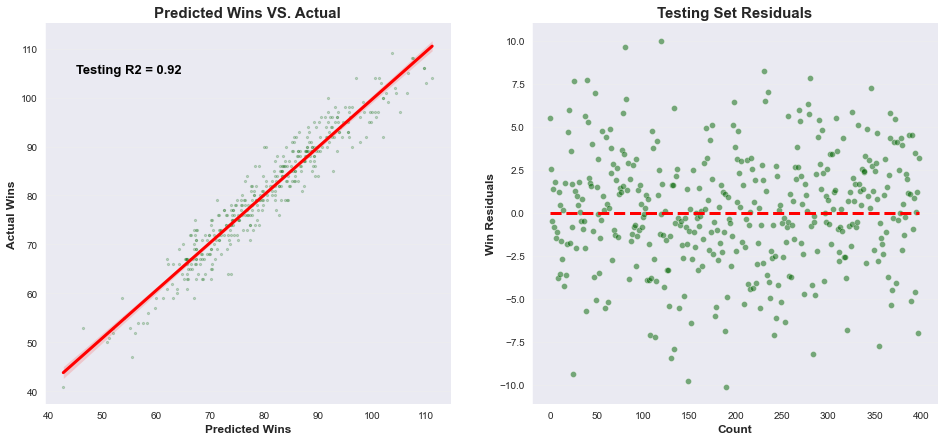

In [70]:
sns.set_style("dark")

# plots TESTING set & residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# plots regplots
sns.regplot(ax = axes[0], 
            x = np.exp(y_pred_test), 
            y = y_test,
            scatter_kws={'s':5, 'alpha': 0.2, 'color': 'darkgreen'},
            line_kws={"color": "red"})

# annotate regplot
axes[0].text(45, 105, "Testing R2 = 0.92", 
             horizontalalignment='left', fontsize=13, color='black', weight = 'bold')

# regplot labels
axes[0].set_xlabel('Predicted Wins', weight = 'bold') 
axes[0].set_ylabel('Actual Wins', weight = 'bold') 
axes[0].set_title('Predicted Wins VS. Actual', weight = 'bold', fontdict = {'fontsize' : 15})

# plots residual
sns.scatterplot(ax = axes[1], 
                x = range(y_test.shape[0]),
                y = resid, 
                alpha=0.5,
                color= "darkgreen")
# plot zero line in residual
sns.lineplot(ax = axes[1], 
             x=range(y_test.shape[0]), y = 0, 
             color='red', linestyle="dashed", linewidth = 3)

# residual labels
axes[1].set_xlabel('Count', weight = 'bold') 
axes[1].set_ylabel('Win Residuals', weight = 'bold') 
axes[1].set_title('Testing Set Residuals', weight = 'bold', fontdict = {'fontsize' : 15})

# removes top and right side axis
sns.despine(right = True)

# set gridline visibility
axes[0].set_axisbelow(True)
axes[0].yaxis.grid(True, color='#EEEEEE')
axes[0].xaxis.grid(False)
axes[1].set_axisbelow(True)
axes[1].yaxis.grid(True, color='#EEEEEE')
axes[1].xaxis.grid(False)

plt.show()
fig.savefig('plots/team_basic_resids.png');

### Assessing the Important Features

Lets now assess which features in the Linear Regression model are the most important when making a prediction. 

In [56]:
top_features

['Attendance',
 'ERA_p',
 'GS_p',
 'CG_p',
 'SV_p',
 'IP_p',
 'TBF_p',
 'H_p',
 'R_p',
 'ER_p',
 'HR_p',
 'BB_p',
 'WP_p',
 'SO_p',
 'BB/9_p',
 'K/BB_p',
 'H/9_p',
 'AVG_p',
 'WHIP_p',
 'BABIP_p',
 'LOB%_p',
 'FIP_p',
 'Age_b',
 'AB_b',
 'PA_b',
 'H_b',
 '1B_b',
 '2B_b',
 'HR_b',
 'R_b',
 'RBI_b',
 'BB_b',
 'IBB_b',
 'HBP_b',
 'SF_b',
 'AVG_b',
 'OBP_b',
 'SLG_b',
 'OPS_b',
 'ISO_b']

In [57]:
# get feature weights
best_model_coef = lr_model.coef_
best_model_coef

array([ 0.00378687,  0.00635988,  0.02602736,  0.03960574,  0.03815954,
        0.09244488,  0.04419998,  0.09237008, -0.13104823,  0.02065427,
        0.01742019,  0.04076582, -0.00059057, -0.031804  , -0.03503475,
        0.00833098, -0.07046225, -0.04956864, -0.01227063,  0.04207942,
       -0.00895019,  0.0086221 ,  0.00291835,  0.14007384, -0.22480636,
       -0.15926686,  0.04401172,  0.01544314,  0.00073862,  0.07970828,
        0.03235221, -0.04379716,  0.00769791, -0.00899202,  0.00214052,
       -0.01931638,  0.06707494, -0.15644276,  0.22168423,  0.01545755])

In [58]:
# check feature importances
feat_imp_series = pd.Series(best_model_coef, 
                            index = pp_X_train.columns)

# preview first 5
feat_imp_series[:5]

0    0.003787
1    0.006360
2    0.026027
3    0.039606
4    0.038160
dtype: float64

We need to index these importance features values with their appropriate values to make sense of which Importance value is associated with which Feature. We'll merge the `top_features_df` with the `feat_imp_df`. 

In [59]:
top_features_list = list(top_features)
top_features_df = pd.DataFrame(top_features_list)
top_features_df.head()

,0
0,Attendance
1,ERA_p
2,GS_p
3,CG_p
4,SV_p


In [60]:
# convert feat_imp_series into a df
feat_imp_df = pd.DataFrame(feat_imp_series)
feat_imp_df.head()

,0
0,0.003787
1,0.006360
2,0.026027
3,0.039606
4,0.038160


In [61]:
# merge the feature names and feature importance dataframes based on index
merged = pd.merge(top_features_df, feat_imp_df, left_index=True, right_index=True)

# rename the new merged dataframe
merged = merged.rename(columns = {'0_x': 'Feature', '0_y': 'Importance'})
merged.head()

,Feature,Importance
0,Attendance,0.003787
1,ERA_p,0.006360
2,GS_p,0.026027
3,CG_p,0.039606
4,SV_p,0.038160


In [62]:
# sort by top 15 most important features
sorted_features = merged.sort_values('Importance', ascending = False)

# create a top 15 features df
top_15_features = sorted_features.head(15)
top_15_features

,Feature,Importance
38,OPS_b,0.221684
23,AB_b,0.140074
5,IP_p,0.092445
7,H_p,0.092370
29,R_b,0.079708
36,OBP_b,0.067075
6,TBF_p,0.044200
26,1B_b,0.044012
19,BABIP_p,0.042079
11,BB_p,0.040766


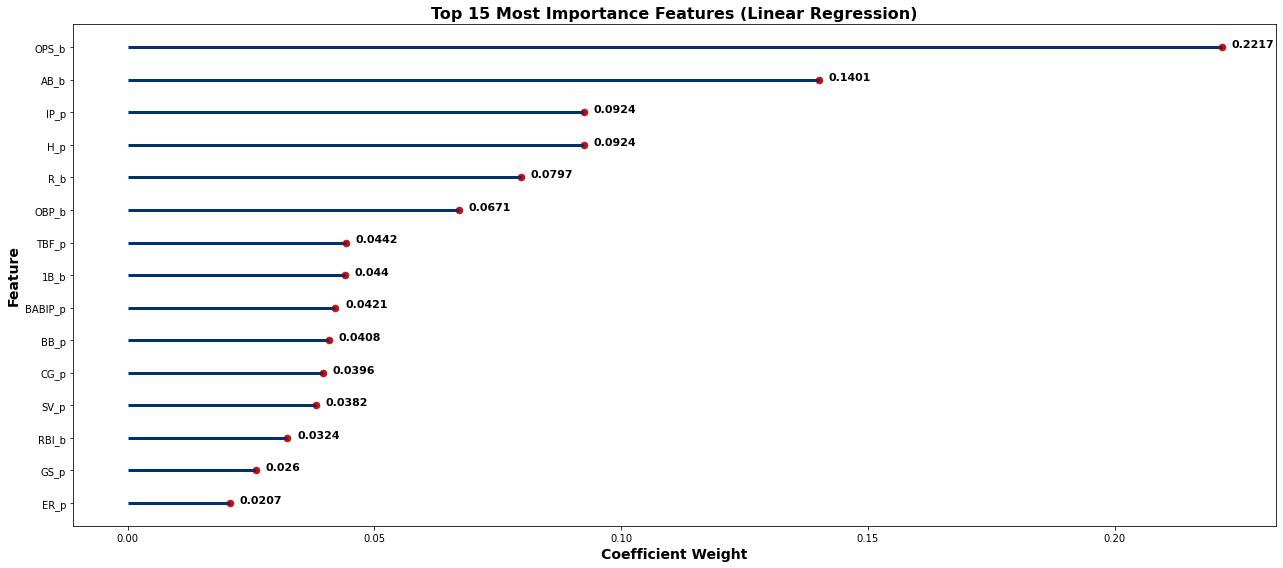

In [63]:
# plot a lollipop plot of top 15 most important features
fig, ax = plt.subplots(figsize=(18, 8))
plt.style.use('bmh')

# sort by descending
top_15_features= top_15_features.sort_values(by = 'Importance')

# plots the lines
plt.hlines(y = top_15_features['Feature'],  # feature
           xmin = 0,
           xmax = top_15_features['Importance'],  # importance
           color = '#013369', linewidth = 3)

plt.scatter(top_15_features['Importance'], # Count values
            top_15_features['Feature'],  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

# annotate the scatter plot values
for idx, row in top_15_features.iterrows():
    ax.annotate(round(row['Importance'],4), (row['Importance'], row['Feature'] ), 
                weight = "bold", fontsize = 11, 
                xytext=(row['Importance'] + 0.002, row['Feature'])) # offset annotate

plt.title('Top 15 Most Importance Features (Linear Regression)', weight = "bold", fontsize = 16)
plt.ylabel('Feature', weight = "bold", fontsize = 14)
plt.xlabel('Coefficient Weight', weight = "bold", fontsize = 14)

plt.tight_layout()
plt.show()
# fig.savefig('images/top_team_important_features.png');